In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
plt.style.use('ggplot')

In [22]:
df_train=pd.read_csv('/content/sample_data/california_housing_train.csv')
df_test=pd.read_csv('/content/sample_data/california_housing_test.csv')
df_train.sample(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
10446,-120.33,37.97,17.0,2530.0,526.0,1024.0,496.0,2.0057,118900.0
9764,-119.66,36.30,18.0,1147.0,202.0,717.0,212.0,3.3681,70500.0


### EDA

In [25]:
df=df_train.copy()

print(df.isnull().sum())

print(df.describe())

print(df.info())


longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
median_house_value          0
rooms_per_person            0
population_per_household    0
bedrooms_per_room           0
dtype: int64
          longitude      latitude  housing_median_age   total_rooms  \
count  17000.000000  17000.000000        17000.000000  17000.000000   
mean    -119.562108     35.625225           28.589353   2643.664412   
std        2.005166      2.137340           12.586937   2179.947071   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.790000     33.930000           18.000000   1462.000000   
50%     -118.490000     34.250000           29.000000   2127.000000   
75%     -118.000000     37.720000           37.000000   3151.250000   
max     -114.310000     41.950000           52.000000  3793

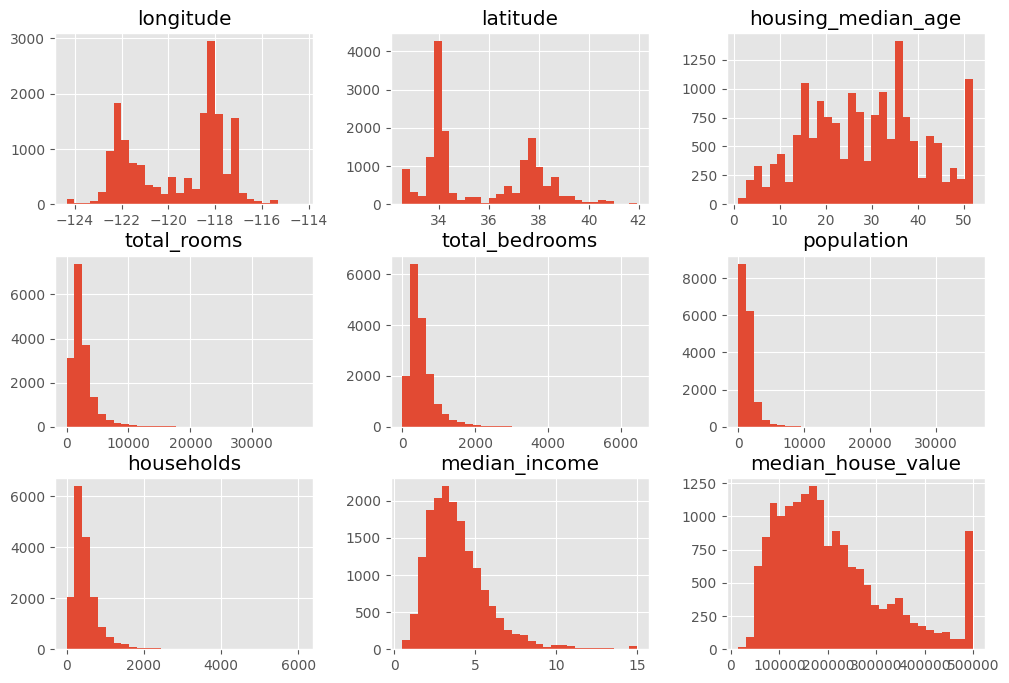

In [10]:
df.hist(figsize=(12, 8), bins=30)
plt.show()

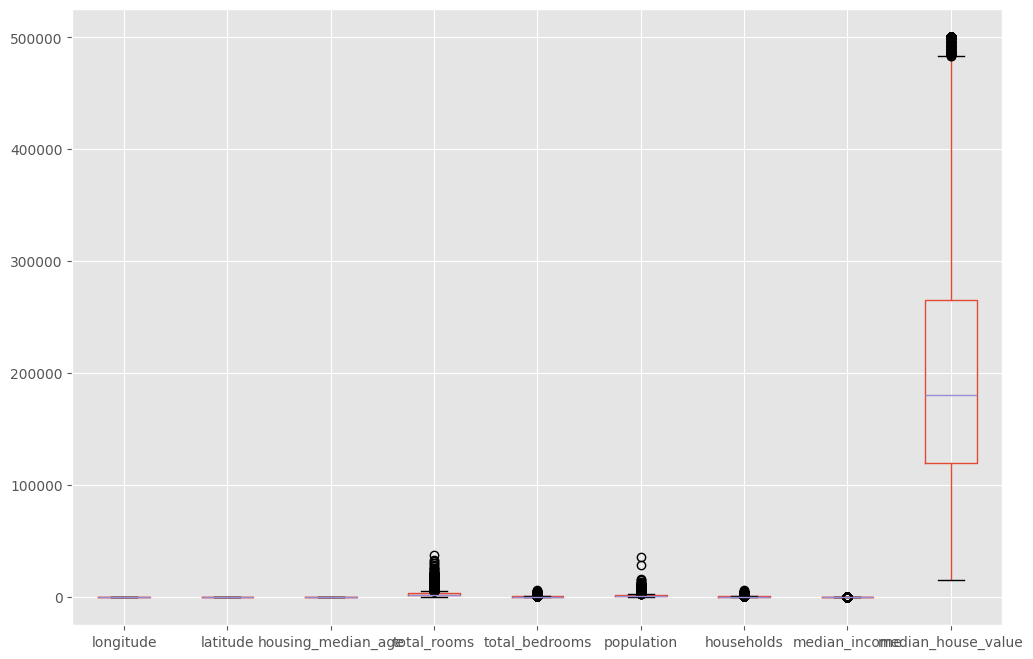

In [11]:
df.boxplot(figsize=(12, 8))
plt.show()


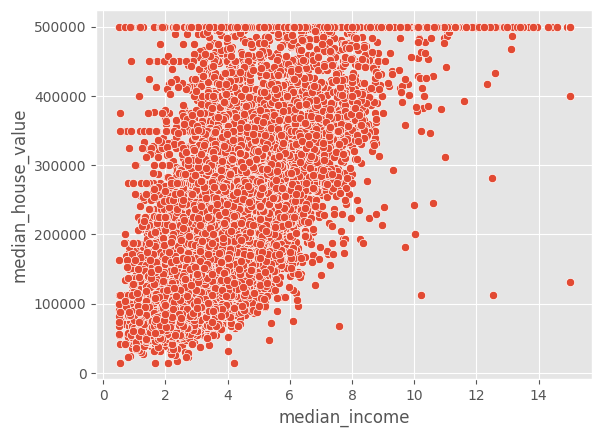

In [12]:
sns.scatterplot(x=df['median_income'], y=df['median_house_value'])
plt.show()

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = df[['median_income', 'total_rooms', 'housing_median_age', 'population']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)


              feature        VIF
0       median_income   4.182617
1         total_rooms  11.549540
2  housing_median_age   3.124396
3          population  10.325695


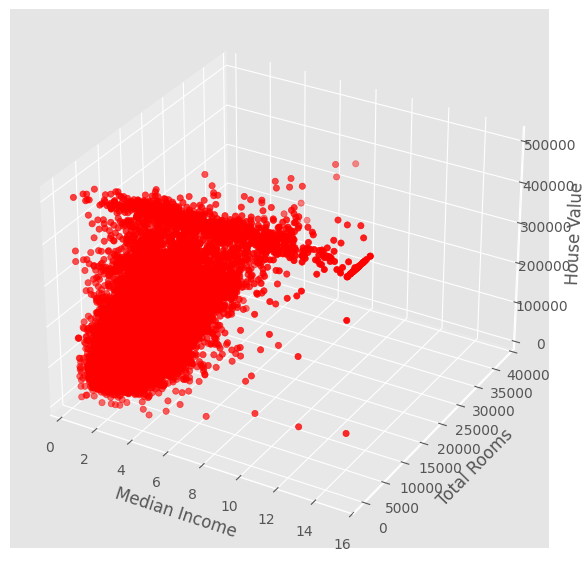

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['median_income'], df['total_rooms'], df['median_house_value'], c='r', marker='o')
ax.set_xlabel('Median Income')
ax.set_ylabel('Total Rooms')
ax.set_zlabel('House Value')
plt.show()


In [23]:
## Feature Engineering for train
df_train['rooms_per_person'] = df_train['total_rooms'] / df_train['population']
df_train['population_per_household'] = df_train['population'] / df_train['households']
df_train['bedrooms_per_room'] = df_train['total_bedrooms'] / df_train['total_rooms']

In [24]:

# Apply same transformations to df_test
df_test['rooms_per_person'] = df_test['total_rooms'] / df_test['population']
df_test['population_per_household'] = df_test['population'] / df_test['households']
df_test['bedrooms_per_room'] = df_test['total_bedrooms'] / df_test['total_rooms']


## Model Building


# Build OLS for Business Interpretation

In [26]:
import statsmodels.api as sm

X_train = df_train.drop(columns=['median_house_value'])
y_train = df_train['median_house_value']

X_train_ols = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_ols).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     2973.
Date:                Sat, 01 Mar 2025   Prob (F-statistic):               0.00
Time:                        02:52:05   Log-Likelihood:            -2.1324e+05
No. Observations:               17000   AIC:                         4.265e+05
Df Residuals:                   16988   BIC:                         4.266e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

p-values: If a feature has a p-value > 0.05, it might not be statistically significant.

R²: Measures how well features explain target variability.

Feature Coefficients: Shows the effect of each feature on house value.

In [17]:
## Base LR Model

X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")


R2 Score: 0.6736
RMSE: 67060.4494


* Base LR Model Metrics is low

# Bagging and Ensemble + Hyperparameter Tuning

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

X_train_model, X_val, y_train_model, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_model, y_train_model)

xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_model, y_train_model)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_test = df_test.drop(columns=['median_house_value'])
y_test = df_test['median_house_value']

y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}\n")

evaluate_model(y_test, y_pred_rf, "RandomForestRegressor")
evaluate_model(y_test, y_pred_xgb, "XGBoostRegressor")


RandomForestRegressor Performance:
MAE: 32657.06, RMSE: 50634.75, R²: 0.80

XGBoostRegressor Performance:
MAE: 31395.37, RMSE: 48232.78, R²: 0.82



In [29]:
from sklearn.model_selection import RandomizedSearchCV

rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}
rf_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), rf_params,
                               n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42, n_jobs=-1)
rf_search.fit(X_train_model, y_train_model)

xgb_search = RandomizedSearchCV(XGBRegressor(random_state=42), xgb_params,
                                n_iter=10, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42, n_jobs=-1)
xgb_search.fit(X_train_model, y_train_model)

# Best Parameters
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

print("Best RandomForest Parameters:", rf_search.best_params_)
print("Best XGBoost Parameters:", xgb_search.best_params_)

# Predictions on Test Data
y_pred_rf_best = best_rf.predict(X_test)
y_pred_xgb_best = best_xgb.predict(X_test)

evaluate_model(y_test, y_pred_rf_best, "Optimized RandomForestRegressor")
evaluate_model(y_test, y_pred_xgb_best, "Optimized XGBoostRegressor")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RandomForest Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Optimized RandomForestRegressor Performance:
MAE: 32591.44, RMSE: 50637.23, R²: 0.80

Optimized XGBoostRegressor Performance:
MAE: 30664.60, RMSE: 47049.60, R²: 0.83



In [32]:
df_test['predicted_value_rf'] = y_pred_rf_best
df_test['predicted_value_xgb'] = y_pred_xgb_best


In [34]:
df_test.to_excel('/content/sample_data/predicted_values.xlsx', index=False)

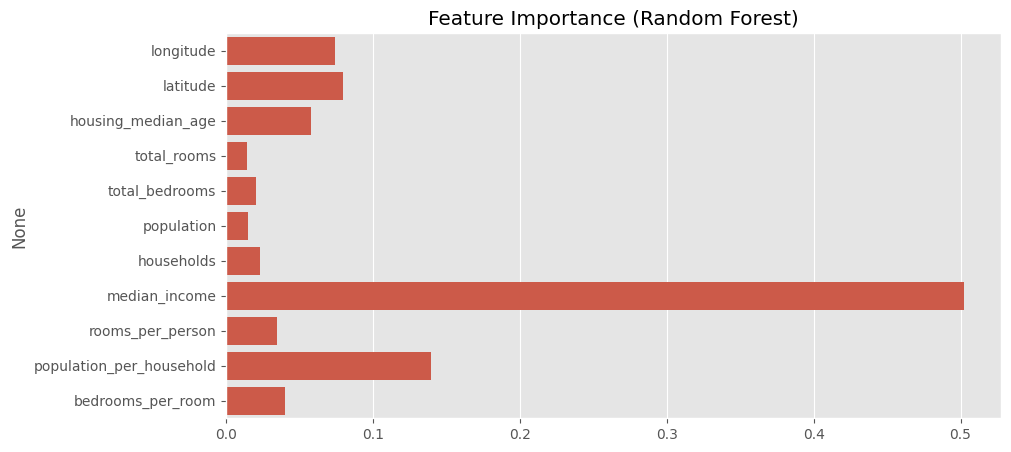

In [31]:
feature_importance = xgb_model.feature_importances_
features = X_train_model.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()


## Interpretation

*  The feature importance plot shows that the most important features for predicting house values are 'total_rooms', 'total_bedrooms', and 'population','bedrooms per-person'.

*  The 'Median_Income' feature is the most important, followed by 'population_per_household', and 'housing_median_age'  and 'population' is the least important.